# Voronoi Mesh

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html

Simple plotting of center points of mesh data, using scipy to construct the corresponding Voronoi mesh.


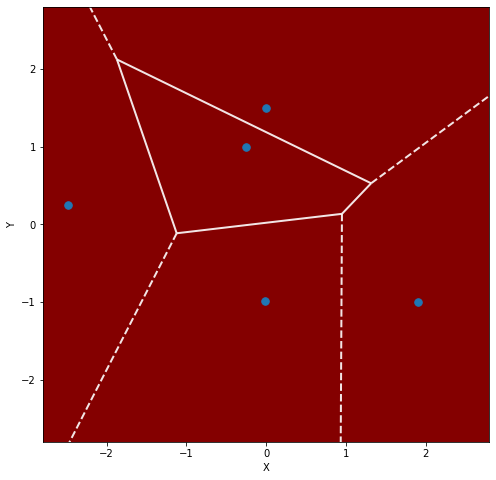

In [1]:
import numpy as np
import matplotlib
#matplotlib.use('agg')
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
points = np.array([[0, 1.5], [-0.01, -0.99], [-2.49, 0.25], [-0.25, 1.0], [1.9, -1.0]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:dark red')
fig = voronoi_plot_2d(vor,ax,show_vertices=False,line_colors='white',line_width=2, line_alpha=0.9, point_size=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-2.8,2.8)
plt.ylim(-2.8,2.8)
plt.show()
plt.close()

# Interpolate mesh from points from AREPO hdf5

I want to read in mesh points from an AREPO output file to reconstruct the voronoi mesh in python in a KDTree. This way, I can query each cell in a FLASH grid and fill it with the appropriate intrinsic field values (density, temperature, pressure) for whichever mesh the cell center falls in.

scipy.interpolate.NearestNDInterpolator
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html
* https://github.com/scipy/scipy/blob/v1.7.1/scipy/interpolate/ndgriddata.py#L20-L111

Steps:
1. Read in AREPO snapshot (~9 million points)
2. Use scipy NearestNDInterpolator to construct mesh and get a field value for 512 grid points (mimicking a FLASH block). Un-modified, NearestNDInterpolator will regenerate the mesh from scratch for each point.
3. Time this process. If it takes longer than 1/1000th of a day (1.5 minutes), then we need to modify.

In [28]:
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt
%matplotlib notebook
import h5py
import numpy as np
import time

In [39]:
def interp_data(data_coords, cell_coords, field_set):
    interp = NearestNDInterpolator(list(zip(data_coords[0], data_coords[1], data_coords[2])), field_set)
    interp_result = interp(cell_coords[0], cell_coords[1], cell_coords[2])
    return interp_result

In [43]:
time1 = time.time()
f = h5py.File('../../AREPO-TORCH/snapshot_550_9.hdf5','r')
coords_set = np.array(f["PartType0"]["Coordinates"])
density_set = np.array(f["PartType0"]["Density"])
velocity_set = np.array(f["PartType0"]["Velocities"])
eAbund_set = np.array(f["PartType0"]["ElectronAbundance"])
intEner_set = np.array(f["PartType0"]["InternalEnergy"])
temp_set = (7./3 - 1)*(intEner_set/1.83e16)*1.0e10*(4*1.67e-23)/(1+3*0.76 + 4*0.76*eAbund_set)
pres_set = (7.3/3 -1)*density_set*intEner_set
x = coords_set[:,0]
y = coords_set[:,1]
z = coords_set[:,2]
data_coords = [x,y,z]
velx = velocity_set[:,0]
vely = velocity_set[:,1]
velz = velocity_set[:,2]
cellX = np.linspace(min(x), max(x), num=512)
cellY = np.linspace(min(y), max(y), num=512)
cellZ = np.linspace(min(z), max(z), num=512)
cell_coords = [cellX,cellY,cellZ]
#interp = NearestNDInterpolator(list(zip(x, y, z)), density_set)
#interp_result = interp(cellX, cellY, cellZ)
dens_interp = interp_data(data_coords, cell_coords, density_set)
temp_interp = interp_data(data_coords, cell_coords, temp_set)
pres_interp = interp_data(data_coords, cell_coords, pres_set)
velx_interp = interp_data(data_coords, cell_coords, velx)
vely_interp = interp_data(data_coords, cell_coords, vely)
velz_interp = interp_data(data_coords, cell_coords, velz)

f.close()
time2 = time.time()
print("elapsed: ", time2-time1)

# Pressure
# P = (gamma - 1)*density*internal_energy

elapsed:  125.10530495643616


In [35]:
print(len(density_set))
print(interp_result)

9619086
[0.00015971 0.00015971 0.00015971 0.00015971 0.00015971 0.00015971
 0.00015971 0.00015971 0.00015971 0.00015971 0.00015971 0.00015971
 0.00015971 0.00018938 0.00018938 0.00018938 0.00018938 0.00018938
 0.00048527 0.00048527 0.00048527 0.00048527 0.00048527 0.00048527
 0.00048527 0.00048527 0.00048527 0.00073156 0.00073156 0.00073156
 0.00082062 0.00082062 0.00085126 0.00085126 0.00084886 0.00092978
 0.00104298 0.00104298 0.00098391 0.0011207  0.0011207  0.0011207
 0.00117641 0.00132504 0.00132504 0.00154783 0.00130039 0.00130039
 0.00107171 0.00107171 0.00088159 0.00088159 0.00087734 0.00087734
 0.00092243 0.00101166 0.00101166 0.00097782 0.00099751 0.00099751
 0.00089399 0.00089399 0.00094346 0.00090608 0.00093455 0.00093455
 0.00095617 0.00095617 0.00099725 0.00104243 0.00104243 0.00109553
 0.00109553 0.00112712 0.00116594 0.00127217 0.00127217 0.00135205
 0.00139869 0.00147145 0.0015365  0.00160379 0.00169233 0.00176074
 0.00176074 0.00185989 0.00185989 0.00187223 0.00188327

[0.3764761  0.44060025 0.43225048 0.45571187 0.62524856 0.42317518
 0.21309353 0.32474167 0.30258417 0.07163966]


<IPython.core.display.Javascript object>


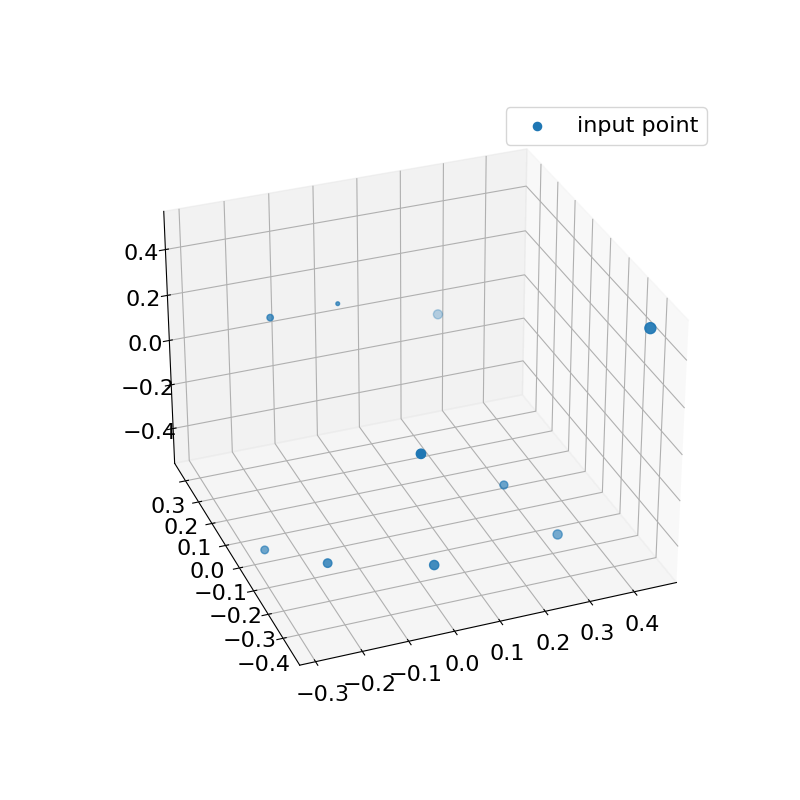

In [13]:
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = rng.random(10) - 0.5
val = np.hypot(x, y)
print(val)
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
Z = np.linspace(min(z), max(z))
X, Y, Z = np.meshgrid(X, Y, Z)  # 3D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y, z)), val)
interp_result = interp(X, Y, Z)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, "k", s=val*100, label="input point")
ax.legend()
#plt.colorbar()
#plt.axis("equal")
plt.show()
